In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [4]:
path.insert(0, '../src')
from data_generator import DataGenerator
from model_trainer import ModelTrainer

In [5]:
from data_transformation import get_better_spectra, get_precise_peaks
dg = DataGenerator('../data/classification_cas_data.csv')
norm_data = dg.df()

In [6]:
data = get_better_spectra(dir='../data/SpectraCsvFiles_WatsonPeakFinder/')
norm_data.sort_values('file_name', inplace=True)
data.sort_values('file_name', inplace=True)
norm_data = pd.merge(data, norm_data, on='file_name')

In [7]:
peaks = get_precise_peaks(norm_data, ['precise_channels', 'precise_intensities'])
norm_data['peaks'] = peaks
dg.set_df(norm_data)

In [8]:
original_data = dg.calibrated_df(True, use_ranges=True, cat=True)
original_data['num_peaks'] = original_data['peaks'].apply(len)
original_data.head()

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks,target,err_prop_slope,err_prop_offset,mass_channels,masses,intensities,num_peaks
0,0 2644.03673 1 3505.01837 2 ...,0 73874 1 1234 2 138 3 ...,0106301.cas,0.387170,-0.275047,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2644.0367300000003, 73874), (3505.0183700000...",2,-0.000660,0.0,"[2644.0367300000003, 3505.0183700000002, 4162....","[1.0050432100670363, 2.012238960596469, 3.0151...","[73874, 1234, 138, 610, 1216, 4159, 8958, 1084...",128
1,0 2647.00072 1 3508.99491 2 ...,0 49864 1 1034 2 168 3 ...,0107316.cas,0.387337,-0.278302,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2647.00072, 49864), (3508.9949100000003, 103...",0,0.000000,0.0,"[2647.00072, 3508.9949100000003, 4164.59326000...","[1.0025002148906825, 2.0105384152423085, 3.009...","[49864, 1034, 168, 4696, 8247, 13992, 17903, 2...",131
2,0 1973.87667 1 2049.07068 2 2122.0...,0 23371 1 74711 2 10386 3 94...,0110203.cas,0.378938,-0.271015,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(1973.8766699999999, 23371), (2049.0706800000...",0,0.000000,0.0,"[1973.8766699999999, 2049.0706800000003, 2122....","[11.991546824303784, 12.996908473240481, 14.01...","[23371, 74711, 10386, 947, 12344, 9121, 265, 4...",19
3,0 672.00298 1 891.90543 2 197...,0 34398 1 304 2 2223 3 ...,0110212.cas,0.379632,-0.269824,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(672.00298, 34398), (891.90543, 304), (1970.9...",2,0.000885,0.0,"[672.00298, 891.90543, 1970.94521, 2046.11295,...","[1.0074229208441592, 2.017669547417123, 12.008...","[34398, 304, 2223, 3521, 5205, 6509, 99, 115, ...",108
4,0 2726.98153 1 3594.53649 2 ...,0 42995 1 602 2 151 3 ...,0116511.cas,0.383481,-0.302161,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2726.98153, 42995), (3594.53649, 602), (4265...",0,0.000000,0.0,"[2726.98153, 3594.53649, 4265.28736, 7866.5038...","[1.0058658675679875, 2.011083088854326, 3.0245...","[42995, 602, 151, 17912, 9536, 17609, 29604, 5...",122


In [9]:
rows = []
lens = []
for data in original_data[(original_data['num_peaks'] < 400) & (original_data['num_peaks'] > 40)].itertuples():
    row = []
    for tup in data.peaks:
        row.append(tup[0])
    rows.append(np.array(row))
    lens.append(len(row))

In [10]:
nn_data = pd.DataFrame(rows)
nn_data.fillna(0, inplace=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler
norm_data = nn_data.copy()
scl = MinMaxScaler()
scl.fit(norm_data)
norm_data = scl.transform(norm_data)
target = original_data[(original_data['num_peaks'] < 400) & (original_data['num_peaks'] > 40)]['target']

### Define Neural Network

In [12]:
from tensorflow.keras.layers import Dense, LayerNormalization, Input, Lambda, Conv1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [22]:
def baseline_model():
    x_in = Input(shape=(398,))
    dense1 = Dense(2000, activation='sigmoid')(x_in)
    dense2 = Dense(500, activation='sigmoid')(dense1)
    dense3 = Dense(200, activation='sigmoid')(dense2)
    dense4 = Dense(3, activation='sigmoid')(dense3)
    model = Model(inputs=x_in, outputs=dense4)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [23]:
estimator = KerasClassifier(build_fn = baseline_model, epochs = 100, batch_size = 10, verbose = 0)

In [24]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [25]:
results = cross_val_score(estimator, norm_data, target, cv = kfold)

In [26]:
results

array([0.42657343, 0.38461539, 0.38461539, 0.4125874 , 0.37762237])

### Neural Network on 'Extreme Peak' Data

In [276]:
from data_transformation import get_isotope_data, get_isotope_mass_list
isotope_data = get_isotope_data()
nom_mass_low = get_isotope_mass_list(isotope_data, False, 2000)
nom_mass_high = get_isotope_mass_list(isotope_data, True, 2000)

In [277]:
from data_transformation import get_peak_data
data = get_peak_data(original_data, nom_mass_low, nom_mass_high)
test_data = data[data['dists_below'].apply(len) >= 20].copy()

In [278]:
X_a = np.vstack(test_data['dists_below'])
X_b = np.vstack(test_data['dists_above'])
X = np.hstack((X_a, X_b))
y = np.array(test_data['target'])

In [291]:
def baseline_model():
    x_in = Input(shape=(40,))
    dense1 = Dense(300, activation='sigmoid')(x_in)
    dense2 = Dense(100, activation='sigmoid')(dense1)
    dense3 = Dense(50, activation='sigmoid')(dense2)
    dense4 = Dense(3, activation='sigmoid')(dense3)
    model = Model(inputs=x_in, outputs=dense4)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [292]:
estimator = KerasClassifier(build_fn = baseline_model, epochs = 150, batch_size = 50, verbose = 0)
kfold = KFold(n_splits = 5, shuffle = True, random_state = 32)

In [293]:
results = cross_val_score(estimator, X, y, cv = kfold)
np.mean(results)

0.6214498162269593

### Neural Network on 'Extreme Peak' Data Dimension Reduced

In [230]:
from data_transformation import dimen_reduc_tsne
above, below = dimen_reduc_tsne(test_data, 'dists', comps=2)
test_data['dists_below_component_x'] = below[:, 0]
test_data['dists_below_component_y'] = below[:, 1]
test_data['dists_above_component_x'] = above[:, 0]
test_data['dists_above_component_y'] = above[:, 1]

In [239]:
X = test_data[['dists_above_component_x', 'dists_above_component_y']]
y = test_data['target']

In [240]:
from tensorflow.keras import Sequential
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu'))
    model.add(Dense(20, input_dim=2, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [241]:
estimator = KerasClassifier(build_fn = create_model, epochs = 150, batch_size = 50, verbose = 0)
kfold = KFold(n_splits = 5, shuffle = True, random_state = 32)

In [242]:
results = cross_val_score(estimator, X, y, cv = kfold)

In [243]:
np.mean(results)

0.6281039476394653

In [225]:
def plot_contour(X, y, model, corr=1,cmap='Paired'):
    x = np.array(X)
    cmap = plt.get_cmap(cmap)
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(x[:, -2], x[:, -1], c=y, cmap=cmap)
    xmin, xmax = x[:,0].min() - 1, x[:,0].max() + 1
    ymin, ymax = x[:,1].min() - 1, x[:,1].max() + 1
    x_span = np.linspace(xmin, xmax, 1000)
    y_span = np.linspace(ymin, ymax, 1000)
    xs, ys = np.meshgrid(x_span, y_span)
    labels = model.predict(np.c_[xs.ravel(), ys.ravel()])

    z = np.array([0 if x < 0.5 else 1 for x in labels])
    z = z.reshape(xs.shape)
    ax.contourf(xs, ys, z, cmap=cmap, alpha=0.5)

In [244]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [245]:
estimator.fit(X_train, y_train)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


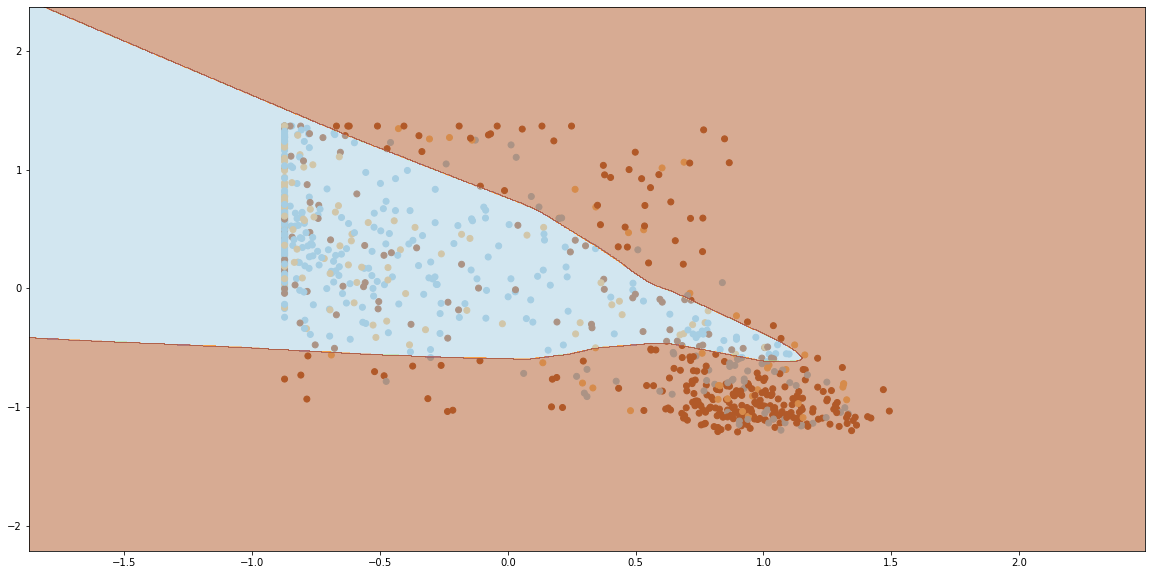

In [228]:
# Contour of PCA Below 1x and Above 1x
plot_contour(np.array(X), np.array(y), estimator)

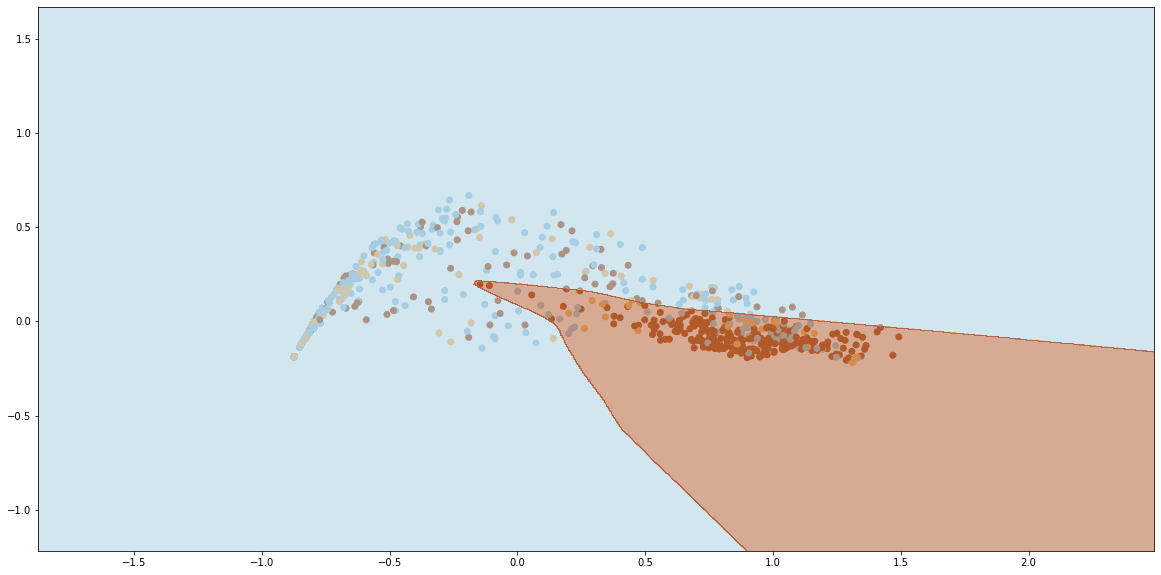

In [217]:
# Contour of PCA Below
plot_contour(np.array(X), np.array(y), estimator)

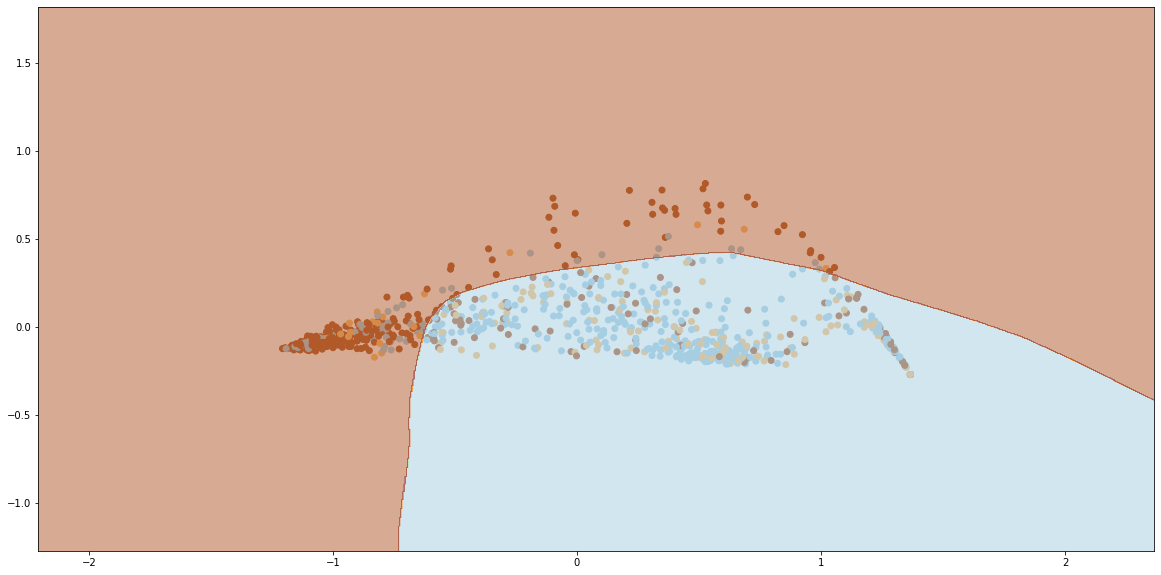

In [209]:
# Contour of PCA Above
plot_contour(np.array(X), np.array(y), estimator)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


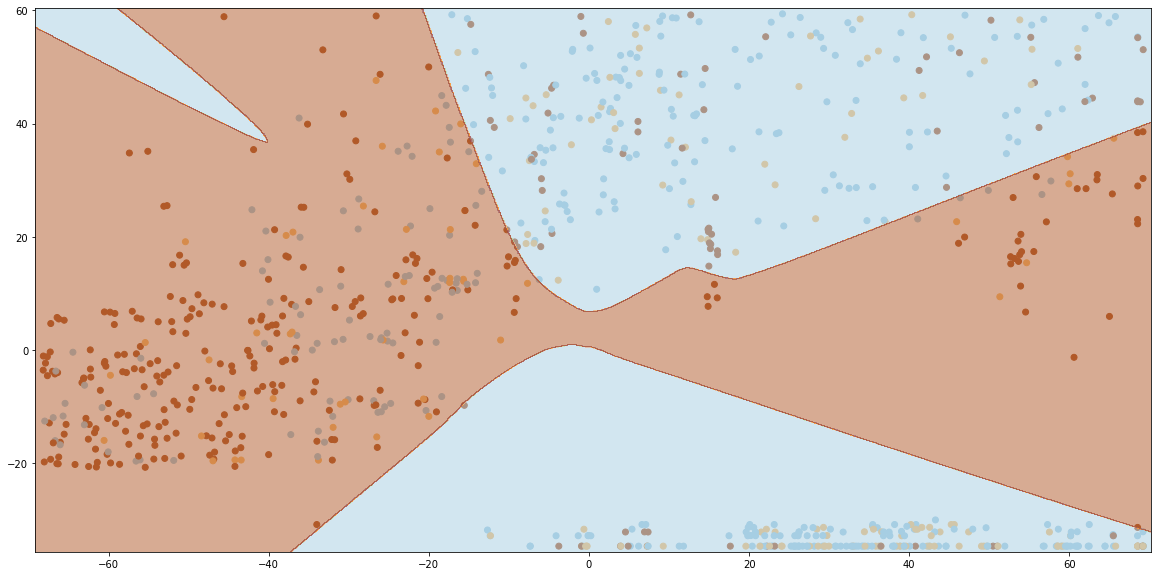

In [190]:
# Contour of tSNE Above 1x and Below 1x
plot_contour(np.array(X), np.array(y), estimator)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


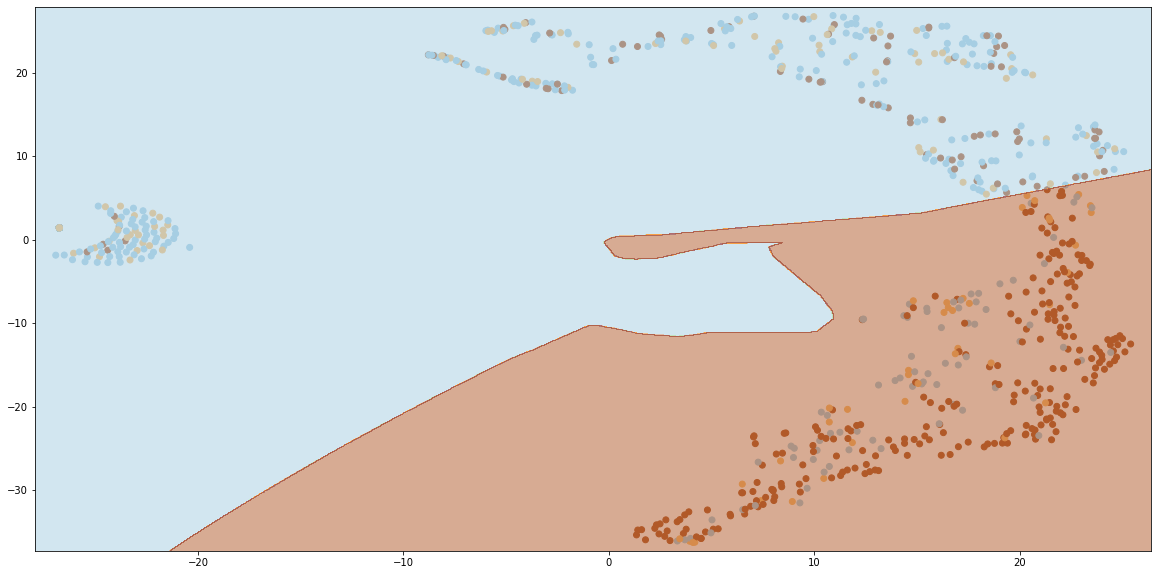

In [238]:
# Contour of tSNE Below
plot_contour(np.array(X), np.array(y), estimator)

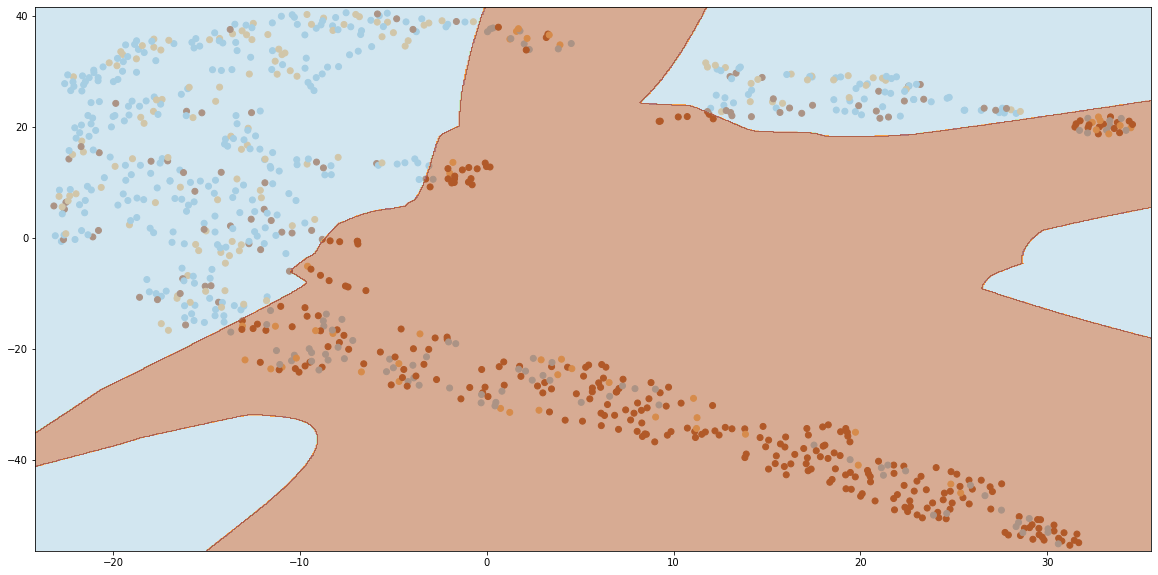

In [246]:
# Contour of tSNE Above
plot_contour(np.array(X), np.array(y), estimator)